In [1]:
# prevent unnecessary display of IPython warnings
import warnings
warnings.filterwarnings('ignore')

# import necessary libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

# initialize main DataFrame
hist_df = pd.DataFrame(columns=['Date'])

# use SimpleImputer for filling missing data by taking the mean of the previous and following data points
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# define stock/ETF ticker symbols for analysis
symbols = ['AAPL','AMZN','DIA','FB','MSFT','NFLX','SPY','TSLA','TWTR','XOM']

# Perform the following for every ticker symbol
for s in symbols:
    
    # Read in the source data as a DataFrame
    sym_df = pd.read_csv('../Data Wrangling/'+s+'.csv', usecols=['Date','Close', 'Adj Close']) 
    
     # Fit and fill missing data using SimpleImputer
    imp_mean.fit(sym_df[['Close', 'Adj Close']])
    imp_df = pd.DataFrame(imp_mean.transform(sym_df[['Close', 'Adj Close']]))
    
    # Rename imputed DataFrame
    imp_df.rename(columns={0:'Close',
                           1:'Adj Close'}, inplace=True)
    imp_df['Date'] = pd.to_datetime(sym_df.Date)
    imp_df['Symbol'] = s
    hist_df = hist_df.append(imp_df,sort=False)

hist_df.set_index('Date',inplace=True)

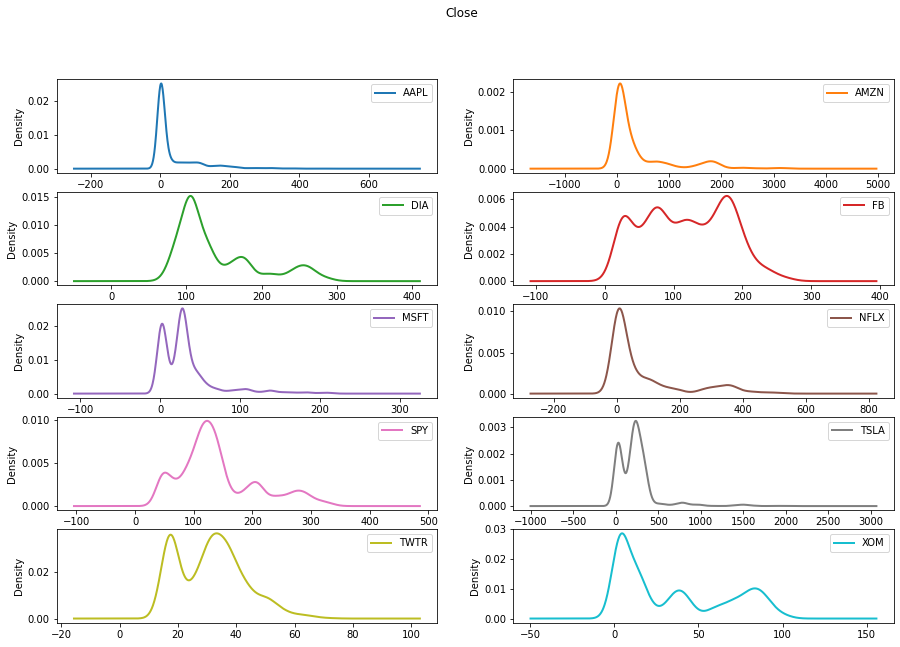

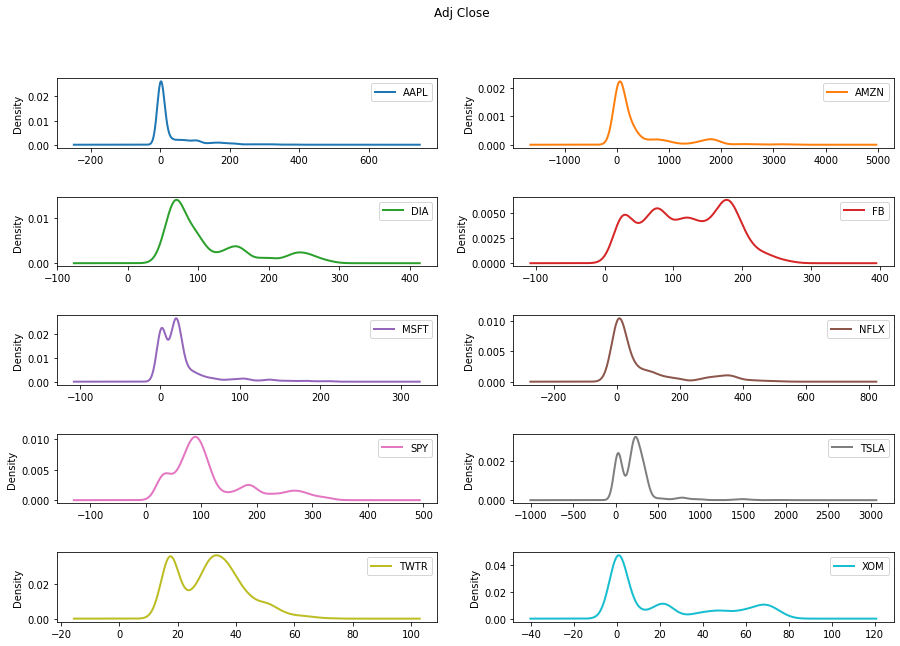

In [2]:
# Display density plots to observe price distribution (i.e. 
# how much of the time a symbol's share was valued at a certain price)
for col in list(hist_df.iloc[:,:2].columns):
    hist_df.pivot(columns = 'Symbol',
                  values = col).plot(kind='density',
                                             figsize=(15,10),
                                             subplots=True, 
                                             layout=(5,2), 
                                             sharex=False, 
                                             sharey=False,
                                             title=col,
                                             linewidth=2)
plt.subplots_adjust(hspace=0.7)
plt.show()

In [22]:
# Initialize dictionaries to store series decomposition
adjClose_decomp = {}
adjClose_seasonal = {}
adjClose_trend = {}
adjClose_noise = {}

# Run time series decomposition on each symbol's Adj Close prices
for s in symbols:
    sym_df = hist_df[hist_df.Symbol==s].loc[:,'Adj Close']
    adjClose_decomp[s] = sm.tsa.seasonal_decompose(sym_df,freq=1)
    adjClose_seasonal[s] = adjClose_decomp[s].seasonal

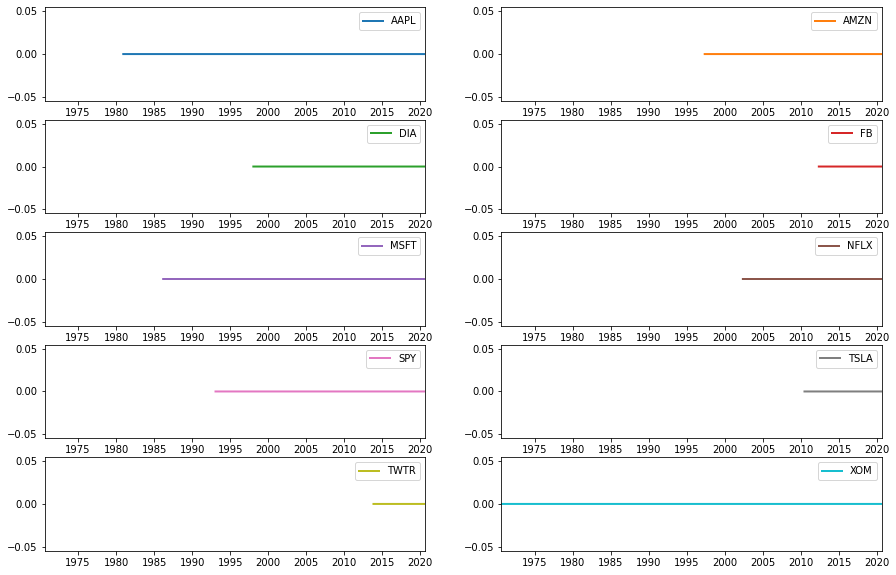

In [23]:
# Create a DataFrame from the jobs_seasonal dictionary
seasonality_df = pd.DataFrame(adjClose_seasonal)

# Remove the label for the index
seasonality_df.index.name = None

# Create a faceted plot of the seasonality_df DataFrame
seasonality_df.plot(figsize=(15,10),
                     subplots=True, 
                     layout=(5,2), 
                     sharex=False, 
                     sharey=False,
                     linewidth=2)

# Show plot
plt.show()

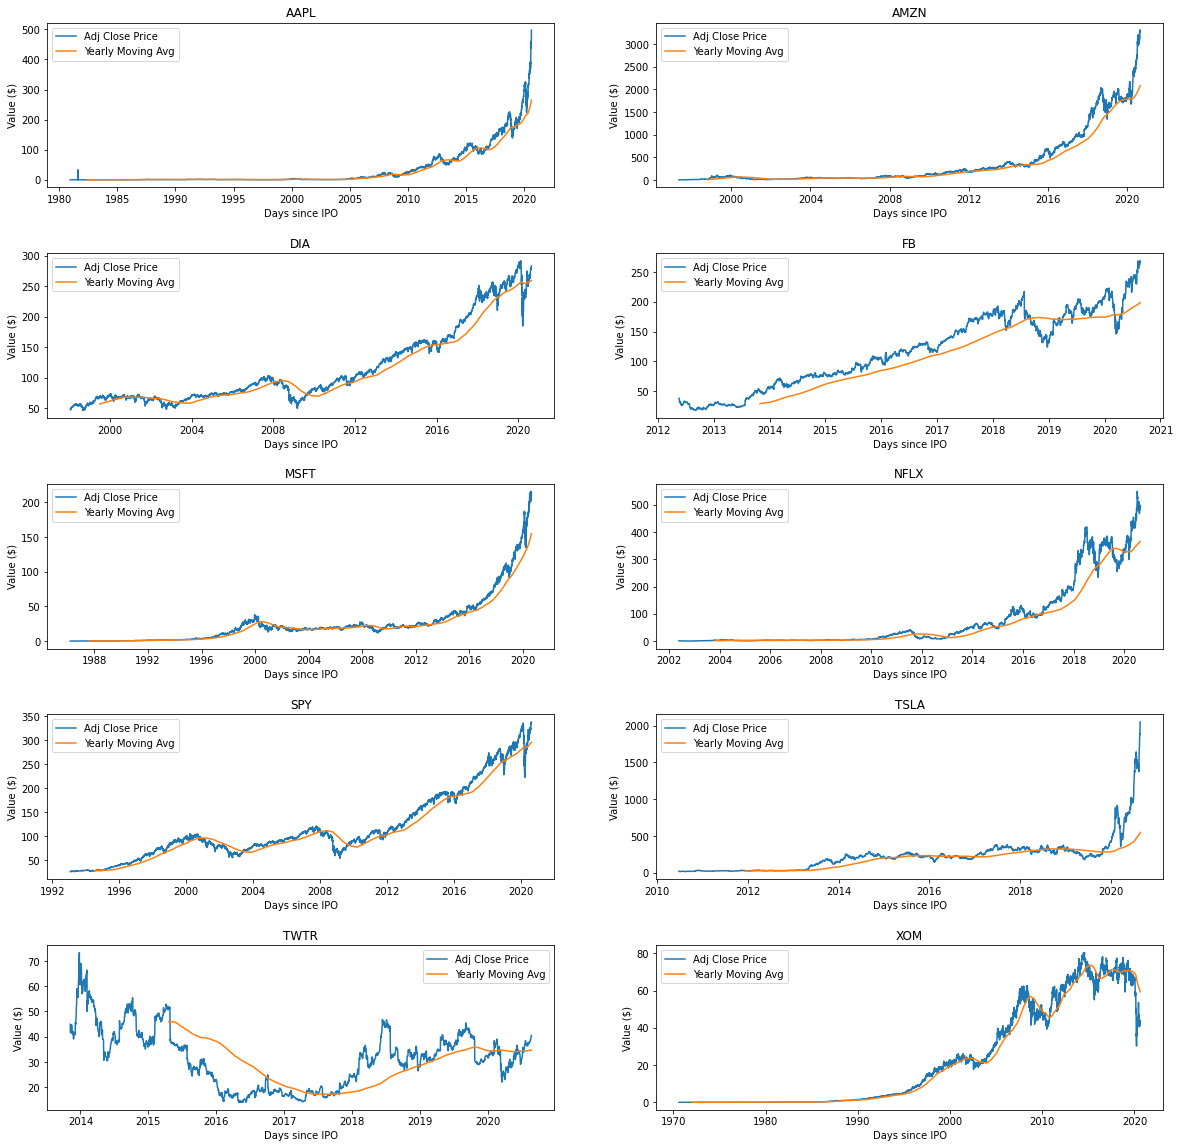

In [24]:
fig,i = plt.subplots(5,2,figsize=(20,20))
n = 0

# Calculate and plot yearly moving average for each ticker symbol to
# focus more on overall trend and less on noise/fluctuations
for a in range(5):
    for b in range(2):
        s = symbols[n]
        sym_df = hist_df[hist_df.Symbol==s]
        yearly_ma = sym_df[['Adj Close']].rolling(window=365).mean()
        yearly_ma['actual'] = sym_df['Adj Close']
        i[a][b].plot(yearly_ma.index,yearly_ma[['actual','Adj Close']])
        i[a][b].legend(['Adj Close Price','Yearly Moving Avg'],loc='best')
        i[a][b].set_xlabel('Days since IPO')
        i[a][b].set_ylabel('Value ($)')
        i[a][b].set_title(s)
        n += 1
        
fig.subplots_adjust(hspace=0.4)
plt.show()